In [1]:
import os
import keras
import random
import numpy as np
import tcc_util as util
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.models import Model
from keras.optimizers import Adam
from keras.models import model_from_json
from keras.applications import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications import NASNetLarge
from keras.applications import ResNet50
from keras.applications import VGG16

import matplotlib.pyplot as plt
import itertools
from skimage import transform
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import classification_report, confusion_matrix

import time

current_milli_time = lambda: int(round(time.time() * 1000))

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
def Inception_Model():
    conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))
    conv_base.traiable = False
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(16, activation='softmax'))
    
    return model

def InceptionResnet_Model():
    conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
    conv_base.traiable = False
    
    for layer in conv_base.layers[:10]:
        layer.trainable = False
    
    x = conv_base.output
    x = Flatten()(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(16, activation="softmax")(x)
    
    model = Model(input = conv_base.input, output = predictions)

#     model = Sequential()
#     model.add(conv_base)
#     for layer in model.layers[:5]:
#         layer.trainable = False
#     model.add(Flatten())
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(16, activation='softmax'))
    
    return model

def NasNetLarge_Model():
    conv_base = NASNetLarge(weights='imagenet', include_top=False, input_shape=(150,150,3))
    conv_base.traiable = False
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(16, activation='softmax'))
    
    return model

def Resnet50_Model():
    conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3))
    conv_base.traiable = False
    x = conv_base.output
    x = Flatten()(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(16, activation="softmax")(x)
    
    model = Model(input = conv_base.input, output = predictions)
    
    return model
    
def VGG16_Model(x=150,y=150):
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(x,y,3))
    conv_base.traiable = False
    x = conv_base.output
    x = Flatten()(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(8, activation="softmax")(x)
    
    model = Model(input = conv_base.input, output = predictions)
    
    return model

def rvi_generator(batch_size=100, img_proc_func = util.preprocess_image, section = 'whole'):
    #
    # Define train, validation and test lists
    #

    train_labels = []
    train_input = []

    #
    # Load validation and training dataset file
    #

    folder = "/media/matheusmortatti/External/rvl-cdip"

    train_file = []
    labels_file = open(folder + "/labels/train.txt")
    for line in labels_file:
        sp = line.split()
        if sp[1] in actual_labels:
            train_file.append(sp)
    labels_file.close()

    #
    # Start training in batches since my gpu can't handle all
    # training data at once.
    #

    train_size = util.file_len(folder + "/labels/train.txt")
    
    def isInDict(d, k):
        for key in d.keys():
            if key == k:
                return True
        return False

    while True:
        random.shuffle(train_file)
        for line in train_file:
            sp = line
            pp_img = img_proc_func(imread(folder + "/images/" + sp[0]), IMAGE_PP_SIZE, section)

            train_input.append(pp_img)
            train_labels.append(actual_labels[sp[1]])

            if len(train_input) >= batch_size:

                #
                # Create training data
                #

                x_train = np.asarray(train_input)
                y_train = util.make_labels(train_labels, n=8)
                
                yield (x_train, y_train)

                #
                # Reset lists for next iteration
                #

                train_input = []
                train_labels = []
        if len(train_input) > 0:

                #
                # Create training data
                #

                x_train = np.asarray(train_input)
                y_train = util.make_labels(train_labels, n=8)
                
                yield (x_train, y_train)

                #
                # Reset lists for next iteration
                #

                train_input = []
                train_labels = []

def train_model(model, tbCallback, img_proc_func = util.preprocess_image):
    #
    # Define train, validation and test lists
    #

    train_labels = []
    val_labels = []
    test_labels = []

    train_input = []
    val_input = []
    test_input = []

    #
    # Load validation and training dataset file
    #

    folder = "/media/matheusmortatti/External/rvl-cdip"

    val_file = []
    labels_file = open(folder + "/labels/val.txt")
    for line in labels_file:
        sp = line.split()
        val_file.append(sp)
    labels_file.close()

    train_file = []
    labels_file = open(folder + "/labels/train.txt")
    for line in labels_file:
        sp = line.split()
        train_file.append(sp)
    labels_file.close()

    #
    # Start training in batches since my gpu can't handle all
    # training data at once.
    #

    trained = 0
    train_size = util.file_len(folder + "/labels/train.txt")

    for i in range(EPOCHS):
        random.shuffle(train_file)
        for line in train_file:
            sp = line
            pp_img = img_proc_func(imread(folder + "/images/" + sp[0]), IMAGE_PP_SIZE)

            train_input.append(pp_img)
            train_labels.append(int(sp[1]))

            if len(train_input) >= TRAIN_STEP:

                trained += len(train_input)

                #
                # Choose a subset of the validation data
                #

#                 ss_val = util.choices(val_file, k=VAL_SIZE)

#                 for v in ss_val:
#                     val_input.append(img_proc_func(imread(folder + "/images/" + v[0]), IMAGE_PP_SIZE))
#                     val_labels.append(int(v[1]))

#                 x_val = np.asarray(val_input)
#                 y_val = util.make_labels(val_labels)

                #
                # Create training data
                #

                x_train = np.asarray(train_input)
                y_train = util.make_labels(train_labels)

                model.fit(x_train, y_train,
                          batch_size=BATCH_SIZE,
                          epochs=1,
                          verbose=1,
#                           validation_data=(x_val, y_val),
                          callbacks=[tbCallback])

                #
                # Reset lists for next iteration
                #

                train_input = []
                train_labels = []
                val_input = []
                val_labels = []

                print("trained: " + str(trained) + " / " + str(train_size))
                
        save_model(model)
                
def save_model(model):
    model_json = model.to_json()
    with open("/media/matheusmortatti/External/document-classifier/models/" + MODEL_NAME + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("/media/matheusmortatti/External/document-classifier/weights/" + MODEL_NAME + ".h5")

In [3]:
IMAGE_PP_SIZE = [150, 150]
EPOCHS = 100
BATCH_SIZE = 100
TRAIN_STEP = 1000
VAL_SIZE = 100

MODEL_NAME = "imgnet_VGG16_rvi_modified"
MODEL_BUILD = VGG16_Model

RELOAD_MODEL = True

actual_labels = {'1':0, '2':1, '7':2, '10':3, '11':4, '13':5, '14':6, '15':7}

In [5]:
if RELOAD_MODEL:
    try:
        json_file = open("/media/matheusmortatti/External/document-classifier/models/" + MODEL_NAME +'.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        model.load_weights("/media/matheusmortatti/External/document-classifier/weights/" + MODEL_NAME + ".h5")
        print("here")
    except:
        model = MODEL_BUILD()
else:
    model = MODEL_BUILD()
    
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])
print(model.summary())

here
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_____

In [5]:
#
# Train the model with the defined values
#
if not os.path.isdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME):
    os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME)

unique_folder = str(current_milli_time())
os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder)

tbCallback = keras.callbacks.TensorBoard(log_dir='/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder, histogram_freq=0,  
          write_graph=True, write_images=True)

NUM_TRAIN_IMAGES = util.file_len("/media/matheusmortatti/External/rvl-cdip" + "/labels/train.txt")
model.fit_generator(rvi_generator(),
                    steps_per_epoch=NUM_TRAIN_IMAGES // 100,
                    verbose=1,
                    epochs=40)
# train_model(model, tbCallback)

Epoch 1/40


/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


3200/3200 [==============================] - 8774s 3s/step - loss: 0.7185 - acc: 0.7544
Epoch 2/40
3200/3200 [==============================] - 8731s 3s/step - loss: 0.3739 - acc: 0.8768
Epoch 3/40
3200/3200 [==============================] - 8789s 3s/step - loss: 0.2725 - acc: 0.9098
Epoch 4/40
3200/3200 [==============================] - 8663s 3s/step - loss: 0.1967 - acc: 0.9344
Epoch 5/40
3200/3200 [==============================] - 8774s 3s/step - loss: 0.1347 - acc: 0.9549
Epoch 6/40
3200/3200 [==============================] - 8663s 3s/step - loss: 0.0915 - acc: 0.9690
Epoch 7/40
3200/3200 [==============================] - 8629s 3s/step - loss: 0.0607 - acc: 0.9796
Epoch 8/40
3200/3200 [==============================] - 8581s 3s/step - loss: 0.0429 - acc: 0.9855
Epoch 9/40
3200/3200 [==============================] - 8548s 3s/step - loss: 0.0325 - acc: 0.9892
Epoch 10/40
3200/3200 [==============================] - 8556s 3s/step - loss: 0.0237 - acc: 0.9923
Epoch 11/40
3200/320

In [7]:

save_model(model)

In [ ]:
# MODEL_NAME = "imgnet_inceptionv3_rvi"

json_file = open("/media/matheusmortatti/External/document-classifier/models/" + MODEL_NAME +'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/media/matheusmortatti/External/document-classifier/weights/" + MODEL_NAME + ".h5")

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [6]:
folder = "/media/matheusmortatti/External/rvl-cdip"
labels_file = open(folder + "/labels/test.txt")

x_val = []
y_val = []
y_pred_total = np.array([])

for line in labels_file:
    sp = line.split()
    if not(sp[1] in actual_labels):
        continue
    x_val.append(util.preprocess_image(imread(folder + "/images/" + sp[0]), IMAGE_PP_SIZE))
    y_val.append(actual_labels[sp[1]])
    
    if len(x_val) >= 5000:
        
        #
        # Predict validation classes
        #
        
        x_val = np.asarray(x_val)
        y_pred = model.predict(x_val)
        y_pred = np.argmax(y_pred, axis=1)
        print(y_pred)
        y_pred_total = np.append(y_pred_total, y_pred)
        print(y_pred_total.shape)
        x_val = []
        
if len(x_val) > 0:
        
    #
    # Predict validation classes
    #

    x_val = np.asarray(x_val)
    y_pred = model.predict(x_val)
    y_pred = np.argmax(y_pred, axis=1)
    y_pred_total = np.append(y_pred_total, y_pred)
    print(y_pred_total.shape)
    x_val = []
        

/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


[6 1 5 ... 7 7 3]
(5000,)
[3 1 3 ... 2 4 7]
(10000,)
[4 6 6 ... 7 1 4]
(15000,)
(19940,)


In [7]:
y_val = np.asarray(y_val)
print('Confusion Matrix')
print(confusion_matrix(y_val, y_pred_total))
print(classification_report(y_val, y_pred_total))

Confusion Matrix
[[2066    6   62   64  139  113   10   46]
 [  11 2471    5    5    6    5    3   10]
 [  76    5 2275   24   17   49   11   15]
 [  72    3   28 2241   70   51   13   27]
 [ 120    2   10   64 2241   24    5   11]
 [  98    9   33   44   26 2150   24   51]
 [  15    2    8   10    6   30 2445   21]
 [  47    5   11   28   17   22   24 2338]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2506
           1       0.99      0.98      0.98      2516
           2       0.94      0.92      0.93      2472
           3       0.90      0.89      0.90      2505
           4       0.89      0.90      0.90      2477
           5       0.88      0.88      0.88      2435
           6       0.96      0.96      0.96      2537
           7       0.93      0.94      0.93      2492

   micro avg       0.91      0.91      0.91     19940
   macro avg       0.91      0.91      0.91     19940
weighted avg       0.91      0.91      0.9

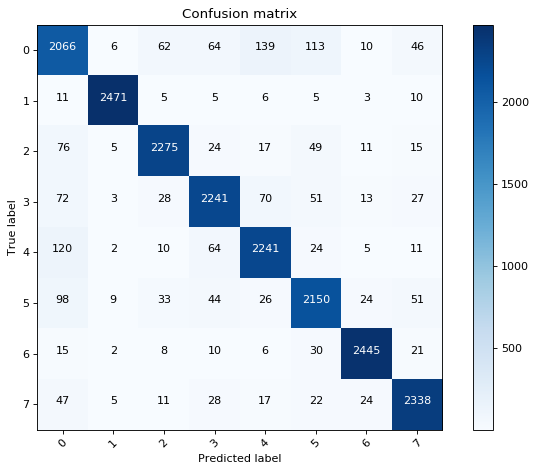

In [8]:
util.plot_confusion_matrix(confusion_matrix(y_val, y_pred_total), np.arange(8))

## Transfer weights from previous model

Now, we get the weights from previous models and train new models with sections of the image.

In [ ]:
HOLISTIC_MODEL_NAME = 'imgnet_VGG16_rvi'
MODEL_NAME += '_header'

In [ ]:
json_file = open("/media/matheusmortatti/External/document-classifier/models/" + HOLISTIC_MODEL_NAME +'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/media/matheusmortatti/External/document-classifier/weights/" + HOLISTIC_MODEL_NAME + ".h5")

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [ ]:
#
# Train the model with the defined values
#
if not os.path.isdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME):
    os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME)

unique_folder = str(current_milli_time())
os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder)

tbCallback = keras.callbacks.TensorBoard(log_dir='/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder, histogram_freq=0,  
          write_graph=True, write_images=True)

NUM_TRAIN_IMAGES = util.file_len("/media/matheusmortatti/External/rvl-cdip" + "/labels/train.txt")
model.fit_generator(rvi_generator(section = 'header'),
                    steps_per_epoch=NUM_TRAIN_IMAGES // 100,
                    verbose=1,
                    epochs=20)
save_model(model)

In [ ]:
save_model(model)

In [ ]:
#
# Train the model with the defined values
#
MODEL_NAME = HOLISTIC_MODEL_NAME + '_footer'

if not os.path.isdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME):
    os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME)

unique_folder = str(current_milli_time())
os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder)

tbCallback = keras.callbacks.TensorBoard(log_dir='/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder, histogram_freq=0,  
          write_graph=True, write_images=True)

NUM_TRAIN_IMAGES = util.file_len("/media/matheusmortatti/External/rvl-cdip" + "/labels/train.txt")
model.fit_generator(rvi_generator(section='footer'),
                    steps_per_epoch=NUM_TRAIN_IMAGES // 100,
                    verbose=1,
                    epochs=20)
save_model(model)

In [ ]:
json_file = open("/media/matheusmortatti/External/document-classifier/models/" + HOLISTIC_MODEL_NAME +'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/media/matheusmortatti/External/document-classifier/weights/" + HOLISTIC_MODEL_NAME + ".h5")

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

#
# Train the model with the defined values
#
MODEL_NAME = HOLISTIC_MODEL_NAME + '_rightbody'

if not os.path.isdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME):
    os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME)

unique_folder = str(current_milli_time())
os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder)

tbCallback = keras.callbacks.TensorBoard(log_dir='/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder, histogram_freq=0,  
          write_graph=True, write_images=True)

NUM_TRAIN_IMAGES = util.file_len("/media/matheusmortatti/External/rvl-cdip" + "/labels/train.txt")
model.fit_generator(rvi_generator(section='right'),
                    steps_per_epoch=NUM_TRAIN_IMAGES // 100,
                    verbose=1,
                    epochs=20)
save_model(model)

In [ ]:
save_model(model)

In [ ]:
model = None
json_file = open("/media/matheusmortatti/External/document-classifier/models/" + HOLISTIC_MODEL_NAME +'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/media/matheusmortatti/External/document-classifier/weights/" + HOLISTIC_MODEL_NAME + ".h5")

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

#
# Train the model with the defined values
#
MODEL_NAME = HOLISTIC_MODEL_NAME + '_leftbody'

if not os.path.isdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME):
    os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME)

unique_folder = str(current_milli_time())
os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder)

tbCallback = keras.callbacks.TensorBoard(log_dir='/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder, histogram_freq=0,  
          write_graph=True, write_images=True)

NUM_TRAIN_IMAGES = util.file_len("/media/matheusmortatti/External/rvl-cdip" + "/labels/train.txt")
model.fit_generator(rvi_generator(section='left'),
                    steps_per_epoch=NUM_TRAIN_IMAGES // 100,
                    verbose=1,
                    epochs=40)
save_model(model)